In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import joblib
import glob
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import glob
import pickle

# 파일 경로 리스트
train_data_list = sorted(glob.glob('/content/drive/MyDrive/GCP/project/odd_group_lettucs_AI/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/MyDrive/GCP/project/odd_group_lettucs_AI/train_target/*.csv'))

# 데이터 로드 함수
def load_data(file_paths):
    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, encoding='euc-kr')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, encoding='latin1')
        dataframes.append(df)
    return dataframes

# 데이터 로드
input_dataframes = load_data(train_data_list)
target_dataframes = load_data(train_target_list)

# 사용자 정의 전처리 클래스 (일간 누적 데이터용)
class PreprocessorDaily(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # 필요 없는 칼럼 제거
        drop_cols = ['obs_time', '일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
        existing_cols = [col for col in drop_cols if col in X.columns]
        X = X.drop(columns=existing_cols)

        # 열 타입 변환
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # 시간 데이터를 일 단위로 변환
        if 'DAT' in X.columns:
            X['day'] = X['DAT']
            # 일 단위로 평균내기
            daily_avg = X.groupby('day').mean().reset_index()
            # 필요 없는 칼럼 제거
            X = daily_avg.drop(columns=['DAT', 'day'])  # 환경 데이터

        return X

# 목표 데이터 로드
def load_target_data(target_dataframes):
    targets = []
    for df in target_dataframes:
        targets.append(df['predicted'])
    return targets

# 전처리 및 목표 데이터 준비
X_data = [PreprocessorDaily().transform(input_df) for input_df in input_dataframes]
y_data = load_target_data(target_dataframes)

# 모든 케이스의 데이터를 하나의 데이터셋으로 결합 (일간 누적)
X_combined = pd.concat(X_data, ignore_index=True)
y_combined = pd.concat(y_data, ignore_index=True)

# 사용자 정의 정규화 및 결측치 처리 클래스
class NormalizerAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        X_scaled = self.scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        X_scaled.fillna(0, inplace=True)
        return X_scaled

# 파이프라인 정의 (일간 누적 데이터용)
pipeline_daily = Pipeline([
    ('preprocessor', PreprocessorDaily()),
    ('normalizer', NormalizerAndImputer()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, n_estimators=100, seed=42))
])

# 데이터 분할 (일간 누적)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# 파이프라인 학습 (일간 누적 데이터용)
pipeline_daily.fit(X_train, y_train)

# 저장할 경로 지정
save_path = '/content/drive/MyDrive/GCP/project/model'
if not os.path.exists(save_path):
    os.makedirs(save_path)
model_filename = 'xgboost_pipeline_daily_test.pkl'
full_path = os.path.join(save_path, model_filename)

# 모델 저장
with open(full_path, 'wb') as f:
    pickle.dump(pipeline_daily, f)

print("Pipeline 모델이 pickle 형식으로 저장되었습니다.")


Pipeline 모델이 pickle 형식으로 저장되었습니다.


[0.09824057 0.28975058 0.768047   1.0412494  1.3261868  0.6899418
 0.6882836  1.2028449  0.7564078  0.44749612 0.5125131  0.84163207
 1.5998263  1.2744108  0.8890797  1.1446747  0.35160983 1.5209491
 1.6462619  1.7690684  0.9010756  0.73342437 0.5173315  1.271096
 0.5830448  1.1575363  1.5077157  2.1424584 ]


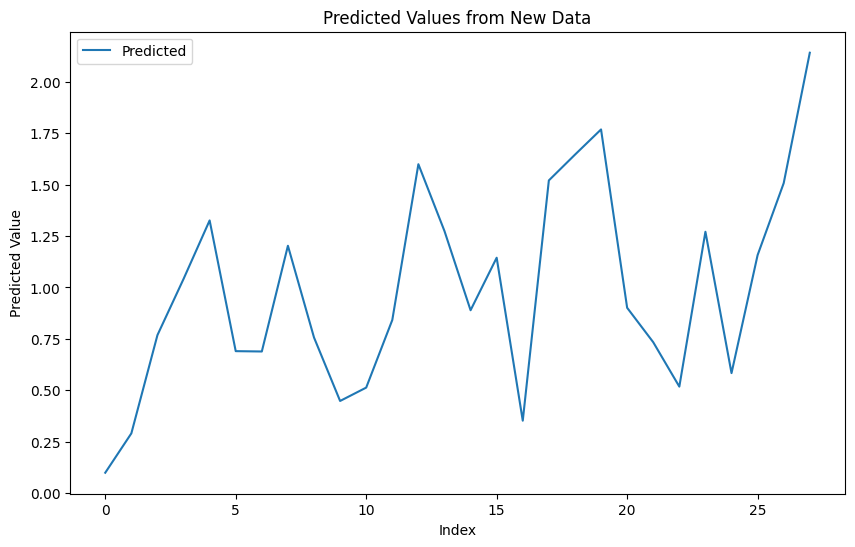

In [ ]:
# 새로운 데이터에 대해 예측을 수행하는 함수
def predict_new_data(input_file):
    # 데이터 로드
    new_data = pd.read_csv(input_file, encoding='utf-8')

    # 전처리 객체 생성
    preprocessor = PreprocessorDaily()

    # 필요 없는 칼럼 제거 및 전처리
    new_data = preprocessor.transform(new_data)

    # 모델 불러오기
    with open(full_path, 'rb') as f:
        loaded_pipeline = pickle.load(f)

    # 예측 수행
    y_pred_new = loaded_pipeline.predict(new_data)

    return y_pred_new

# 결과 시각화 함수
def plot_predictions(y_pred_new, title='Predicted Values'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_new, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Predicted Value')
    plt.title(title)
    plt.legend()
    plt.show()

# 새로운 파일에 대해 예측 수행 및 시각화
new_file_path = '/content/drive/MyDrive/GCP/project/odd_group_lettucs_AI/test_input/TEST_02.csv'
predictions = predict_new_data(new_file_path)
print(predictions)

# 예측 결과 시각화
plot_predictions(predictions, 'Predicted Values from New Data')

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import glob
import pickle
import os

# 파일 경로 리스트
train_data_list = sorted(glob.glob('/content/drive/MyDrive/GCP/project/odd_group_lettucs_AI/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/MyDrive/GCP/project/odd_group_lettucs_AI/train_target/*.csv'))

# 데이터 로드 함수
def load_data(file_paths):
    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, encoding='euc-kr')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, encoding='latin1')
        dataframes.append(df)
    return dataframes

# 데이터 로드
input_dataframes = load_data(train_data_list)
target_dataframes = load_data(train_target_list)

# 사용자 정의 전처리 클래스 (일간 누적 데이터용)
class PreprocessorDaily(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # 필요 없는 칼럼 제거
        drop_cols = ['obs_time', '일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
        existing_cols = [col for col in drop_cols if col in X.columns]
        X = X.drop(columns=existing_cols)

        # 열 타입 변환
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # 시간 데이터를 일 단위로 변환
        if 'DAT' in X.columns:
            X['day'] = X['DAT']
            # 일 단위로 평균내기
            daily_avg = X.groupby('day').mean().reset_index()
            # 필요 없는 칼럼 제거
            X = daily_avg.drop(columns=['DAT', 'day'])  # 환경 데이터

        return X

# 목표 데이터 로드
def load_target_data(target_dataframes):
    targets = []
    for df in target_dataframes:
        targets.append(df['predicted'])
    return targets

# 전처리 및 목표 데이터 준비
X_data = [PreprocessorDaily().transform(input_df) for input_df in input_dataframes]
y_data = load_target_data(target_dataframes)

# 모든 케이스의 데이터를 하나의 데이터셋으로 결합 (일간 누적)
X_combined = pd.concat(X_data, ignore_index=True)
y_combined = pd.concat(y_data, ignore_index=True)

# 사용자 정의 정규화 및 결측치 처리 클래스
class NormalizerAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        X_scaled = self.scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        X_scaled.fillna(0, inplace=True)
        return X_scaled

# 파이프라인 정의 (일간 누적 데이터용)
pipeline_daily = Pipeline([
    ('preprocessor', PreprocessorDaily()),
    ('normalizer', NormalizerAndImputer()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, n_estimators=100, seed=42))
])

# 데이터 분할 (일간 누적)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# 파이프라인 학습 (일간 누적 데이터용)
pipeline_daily.fit(X_train, y_train)

# 저장할 경로 지정
save_path = '/content/drive/MyDrive/GCP/project/model'
if not os.path.exists(save_path):
    os.makedirs(save_path)
model_filename = 'xgboost_pipeline_daily_test2.pkl'
full_path = os.path.join(save_path, model_filename)

# 모델 저장
with open(full_path, 'wb') as f:
    pickle.dump(pipeline_daily, f)

print("Pipeline 모델이 pickle 형식으로 저장되었습니다.")


Pipeline 모델이 pickle 형식으로 저장되었습니다.


In [ ]:
# 예측
y_pred_train = pipeline_daily.predict(X_train)
y_pred_test = pipeline_daily.predict(X_test)

# 평가 (MSE, MAE)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

# RMSE 계산
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train MSE: 5.7916
Test MSE: 5.4115
Train MAE: 1.8861
Test MAE: 1.6859
Train RMSE: 2.4066
Test RMSE: 2.3263
